## <center><ins>Trabajo Práctico 1: Reservas de hotel</ins></center>
#### <center>*Checkpoint 3: Ensambles - Stacking y Voting*</center>
##### <center>75.06 / 95.58 Organización de Datos - FIUBA</center>
##### <center>Ing. Rodríguez - 1°C 2023</center>
---
#### <center>**Grupo 31 - "Datazo":**</center>
<center> Michael Mena - 102685</center>
<center>Pablo Brocca - 104256</center>
<center>Diego Kisinovsky - 106203</center>

---
---

## Carga de datos y librerías

In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##### Imports:

In [ ]:
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from IPython.display import Image

# Modelos y métricas
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, KFold, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from six import StringIO

#Keras
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras import optimizers
from keras.callbacks import EarlyStopping
import keras.backend as K

from keras.models import Model
from keras.layers import Input, Dense, concatenate
from keras import optimizers

# Preprocesamiento
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Manejo de modelos
from pickle import dump
from pickle import load
from keras.models import load_model


# Configuración de warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#Emsables
from collections import defaultdict
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
import plotly.graph_objects as go
%matplotlib inline

#Voting
from sklearn.ensemble import VotingClassifier

##### Lectura del dataset preprocesado:

In [ ]:
hotel_train = pd.read_csv('./dataset/hotels_train_preprocesado.csv')

##### Importacion de modelos:

In [ ]:


# @tf.keras.utils.register_keras_serializable()
def f1_score(y_true, y_pred):
    # Cálculo de la métrica F1-score
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    precision = tp / (K.sum(K.round(K.clip(y_pred, 0, 1))) + K.epsilon())
    recall = tp / (K.sum(K.round(K.clip(y_true, 0, 1))) + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return f1

keras.utils.get_custom_objects().update({'f1_score': f1_score})

# keras.utils.custom_object_scope({'f1_score': f1_score})

# keras.utils.get_custom_objects()['f1_score'] = f1_score


In [ ]:
svm_norm = load(open('./modelos/model_svm_norm.pkl', 'rb'))
rf_cv = load(open('./modelos/model_randomforest_randomcv.pkl', 'rb'))
knn_cv = load(open('./modelos/model_knn_randomcv.pkl', 'rb'))
xgb_cv = load(open('./modelos/model_xgboost_randomcv.pkl', 'rb'))
dt_cv = load(open('./modelos/model_decisiontree_randomcv.pkl', 'rb'))
rn_norm = load_model('./modelos/model_rn_adadelta_1.h5')
# rn_norm = load(open('./modelos/modelo_rn_adadelta_1.pkl', 'rb'))

[20:48:45] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



##### Preparación de features:

In [ ]:
features = hotel_train.drop(['is_canceled'],axis=1).columns
          
target = 'is_canceled'

features.tolist()

['lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_day_of_month',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'stays_in_nights',
 'total_of_guests',
 'room_type_unchanged',
 'country_encoded',
 'customer_type_Group',
 'customer_type_Transient',
 'customer_type_Transient-Party',
 'deposit_type_Non Refund',
 'deposit_type_Refundable',
 'hotel_Resort Hotel',
 'distribution_channel_Direct',
 'distribution_channel_GDS',
 'distribution_channel_TA/TO',
 'distribution_channel_Undefined',
 'market_segment_Complementary',
 'market_segment_Corporate',
 'market_segment_Direct',
 'market_segment_Groups',
 'market_segment_Offline TA/TO',
 'market_segment_Online TA',
 'market_segment_Undefined',
 'meal_FB',
 'meal_HB',
 'meal_SC',
 'meal_Undefined']

---

## Armado y entrenamiento con Ensamble de Modelos

##### Preparación de features:

In [ ]:
features = hotel_train.drop(['is_canceled'],axis=1).columns
          
target = 'is_canceled'

features.tolist()

['lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_day_of_month',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'stays_in_nights',
 'total_of_guests',
 'room_type_unchanged',
 'country_encoded',
 'customer_type_Group',
 'customer_type_Transient',
 'customer_type_Transient-Party',
 'deposit_type_Non Refund',
 'deposit_type_Refundable',
 'hotel_Resort Hotel',
 'distribution_channel_Direct',
 'distribution_channel_GDS',
 'distribution_channel_TA/TO',
 'distribution_channel_Undefined',
 'market_segment_Complementary',
 'market_segment_Corporate',
 'market_segment_Direct',
 'market_segment_Groups',
 'market_segment_Offline TA/TO',
 'market_segment_Online TA',
 'market_segment_Undefined',
 'meal_FB',
 'meal_HB',
 'meal_SC',
 'meal_Undefined']

In [ ]:
cols_categorical = ['room_type_unchanged',
                    'country_encoded',
                   'customer_type_Group',
                   'customer_type_Transient',
                   'customer_type_Transient-Party',
                   'deposit_type_Non Refund',
                   'deposit_type_Refundable',
                   'hotel_Resort Hotel',
                   'distribution_channel_Direct',
                   'distribution_channel_GDS',
                   'distribution_channel_TA/TO',
                   'distribution_channel_Undefined',
                   'market_segment_Complementary',
                   'market_segment_Corporate',
                   'market_segment_Direct',
                   'market_segment_Groups',
                   'market_segment_Offline TA/TO',
                   'market_segment_Online TA',
                   'market_segment_Undefined',
                   'meal_FB',
                   'meal_HB',
                   'meal_SC',
                   'meal_Undefined']

In [ ]:
cols_to_normalize =[col for col in hotel_train.columns if col not in cols_categorical]

In [ ]:
cols_to_normalize.remove('is_canceled')
cols_to_normalize

['lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_day_of_month',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'stays_in_nights',
 'total_of_guests']

#### Definicion funciones:

In [ ]:
#Funcion para evaluar los modelos 5fold -CV (repite 2 veces)
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, verbose=1, n_jobs=-1, error_score='raise')
    return scores

In [ ]:
def bar_plot_results(model_scores, name):
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    means = [np.mean(result) for result in results]
    errors = [np.std(result) for result in results]
    fig = go.Figure()
    for model, mean, error in zip(model_names, means, errors):
        fig.add_trace(go.Bar(
            x=[model],
            y=[mean],
            name=model,
            error_y=dict(
                type='data',
                array=[error],
                visible=True,
                color='black',
                thickness=1,
                width=5
            )
        ))
    
    fig.update_layout(
        title='Score de Accuracy de cada modelo usando 5-Fold Cross-Validation',
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
        xaxis_title='Model',
        yaxis_title='Accuracy',
        showlegend=False
    )
    fig.show()

In [ ]:
# def evaluate_model_RN(model, x, y, n_splits=5):
#     kf = KFold(n_splits=n_splits, shuffle=True, random_state=25)
#     scores = []
#     for train_index, val_index in kf.split(x):
#         x_train, x_val = x.iloc[train_index], x.iloc[val_index]
#         y_train, y_val = pd.DataFrame(y).iloc[train_index], pd.DataFrame(y).iloc[val_index]

#         model.fit(x_train, y_train)
#         score = model.evaluate(x_val, y_val)
#         scores.append(score[1])  # Obtener el valor de binary_accuracy
#     return np.array(scores)

# El 'score' para RN es de la siguiente forma [0.26240328, 0.88230461, 0.95784497,0.88399041]
# Donde Loss: 0.26240328, Binary Accuracy: 0.88230461, AUC: 0.95784497, F1 Score: 0.88399041

# Se usa para KerasClassifier
def evaluate_model_RN(model, x, y, n_splits=5, n_repeats=2):
    kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=25)
    scores = []
    for train_index, val_index in kf.split(x):
        x_train, x_val = x.iloc[train_index], x.iloc[val_index]
        y_train, y_val = pd.DataFrame(y).iloc[train_index], pd.DataFrame(y).iloc[val_index]

        model.fit(x_train, y_train)
        score = model.score(x_val, y_val)
        scores.append(score)  # Obtener el valor de score
    return np.array(scores)


In [ ]:
def create_model_rn():
    # Calcula la cantidad de clases
    cant_clases = 1 # Como es un problema de clasificación binaria, la cantidad de clases es 1

    # Calcula la cantidad de features
    d_in = len(features)
    d_in_combined = len(x_train_norm.columns)

    # Definir las capas de entrada
    input_combined = Input(shape=(d_in_combined,))

    # Capas para las columnas codificadas (categóricas)
    x = Dense(48, activation='relu', kernel_initializer='uniform')(input_combined)
    x = Dense(48, activation='relu', kernel_initializer='uniform')(x)
    encoded_outputs = Dense(cant_clases, activation='relu')(x)

    # Capas para las columnas numéricas (opcional)
    y = Dense(32, activation='relu', kernel_initializer='uniform')(input_combined)
    y = Dense(32, activation='relu', kernel_initializer='uniform')(y)

    # Combinar las salidas de las capas codificadas y numéricas
    combined = concatenate([encoded_outputs, y])

    # Capa de salida
    output = Dense(cant_clases, activation='sigmoid')(combined)

    # Crear el modelo
    model = Model(inputs=input_combined, outputs=output)

    # Configurar el optimizador
    optimizer = optimizers.Adadelta(learning_rate=0.1) # Alternativas: Adamax (Más lento), otros No convergen

    # Compilar el modelo
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', # sparse_categorical_crossentropy, categorical_crossentropy
                  metrics=['binary_accuracy', 
                           'AUC', 
                          #  'f1_score'
                           ])
    
    model.load_weights('./modelos/model_rn_adadelta_1.h5')

    return model

#### Train-Test Split:

In [ ]:
# Separamos un 20% de los datos para test
x_train, x_test, y_train, y_test = train_test_split(hotel_train[features].values, 
                                                    hotel_train[target].values, 
                                                    test_size=0.2,    
                                                    random_state=42,  
                                                    stratify=hotel_train[target].values) 

# Verificamos cantidad de datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

# Verificamos como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 48682
# Datos Prueba: 12171
% Positivos Entrenamiento: 50.433
% Positivos Prueba: 50.431


#### Normalización:
Versión estandarizada con $\frac{x_i - mean(x)}{stdev(x)}$

In [ ]:
x_train_to_norm = pd.DataFrame(x_train, columns=features).drop(cols_categorical, axis=1)
x_test_to_norm = pd.DataFrame(x_test, columns=features).drop(cols_categorical, axis=1)

In [ ]:
x_train_categorical = pd.DataFrame(x_train, columns=features).drop(cols_to_normalize, axis=1)
x_test_categorical = pd.DataFrame(x_test, columns=features).drop(cols_to_normalize, axis=1)

In [ ]:
# Aplicar la transformación de escalado de características solo a las columnas seleccionadas
stand_scaler = StandardScaler()
x_train_norm_scaled = stand_scaler.fit_transform(x_train_to_norm)
x_test_norm_scaled = stand_scaler.transform(x_test_to_norm)

# Convertir las matrices escaladas nuevamente en DataFrames
x_train_norm_scaled = pd.DataFrame(x_train_norm_scaled, columns=cols_to_normalize)
x_test_norm_scaled = pd.DataFrame(x_test_norm_scaled, columns=cols_to_normalize)

# Agregar las columnas categoricas a las matrices escaladas
x_train_norm = pd.concat([x_train_norm_scaled, x_train_categorical], axis=1)
x_test_norm = pd.concat([x_test_norm_scaled, x_test_categorical], axis=1)

#### Entrenamiento y evaluación de modelos:
Se evaluarán los siguientes modelos:
- Random Forest
- SVM
- KNN
- XGBoost
- Arbol de Decision
- Red Neuronal

In [ ]:
# rn_norm = KerasClassifier(build_fn=create_model_rn)

Cada uno de los modelos se evaluará utilizando una estrategia de validación cruzada de cinco folds repetida dos veces. En cada iteracion cada modelo se entrenó en el 80 % de los datos y se validó en el 20 % restante.

Este método da como resultado 10 puntajes de performance diferentes para cada modelo que se almacenarán en un diccionario.

In [ ]:
# Creo una instancia de la red neuronal, se configura el modelo y se cargan los pesos
rn_norm = KerasClassifier(build_fn=create_model_rn)
# rn_norm = create_model_rn()

base_model = {'RN': rn_norm, 'SVM': svm_norm, 'RF': rf_cv, 'KNN': knn_cv, 'XGB': xgb_cv, 'DT': dt_cv}
# base_model = {'RN': rn_norm}

#Guadamos los resultados de las métricas de cada modelo
model_scores = defaultdict()

#Entrenamos los clasificadores
for name, model in base_model.items():
    print('Entrenando modelo: {}'.format(name))
    if name == 'RN':
        score = evaluate_model_RN(model, x_train_norm, y_train)
    else:
        score = evaluate_model(model, x_train_norm, y_train)
    model_scores[name] = score

Entrenando modelo: RN
305/305 [==============================] - 1s 2ms/step
Entrenando modelo: SVM


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Entrenando modelo: RF


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Entrenando modelo: KNN


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Entrenando modelo: XGB


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Entrenando modelo: DT


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.1s finished


In [ ]:
model_scores

defaultdict(None,
            {'RN': array([0.87429393, 0.88322892, 0.88249795, 0.88362777, 0.88249795,
                    0.8812776 , 0.88651535, 0.88218981, 0.88506574, 0.87880033]),
             'SVM': array([0.84091609, 0.84225121, 0.84593262, 0.83709942, 0.85065735,
                    0.84009448, 0.8419431 , 0.84233772, 0.84315941, 0.84377568]),
             'RF': array([0.86967238, 0.86618055, 0.86822104, 0.864318  , 0.87078882,
                    0.86833727, 0.8708021 , 0.86493426, 0.86647494, 0.86822104]),
             'KNN': array([0.84286741, 0.83578104, 0.84028348, 0.83011504, 0.84428924,
                    0.83649995, 0.8420458 , 0.83966721, 0.84161873, 0.8386401 ]),
             'XGB': array([0.88261271, 0.87963438, 0.88578472, 0.87859491, 0.88424404,
                    0.88066139, 0.88261271, 0.88311422, 0.88198439, 0.88670912]),
             'DT': array([0.85293211, 0.85375372, 0.85959326, 0.85322514, 0.85527938,
                    0.85765636, 0.85426723, 0.8523007

### Stacking

#### Armamos el emsamble con StackingCVClassifier, que utiliza como estimador final un LogisticRegression.

In [ ]:
#Modelos bases
base_models = [('DT', dt_cv), ('KNN', knn_cv), ('SVM', svm_norm), ('RF', rf_cv), ('XGB', xgb_cv), ('RN', rn_norm)]

#Meta Modelo
meta_model = LogisticRegressionCV()

#Ensamble con stacking
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, 
                                    # verbose=1, 
                                    # n_jobs=-1
                                    )



In [ ]:
#Evaluo en conjunto de test
#stacking_model.fit(x_train,y_train).score(x_test,y_test)
stacking_model.fit(x_train_norm,y_train)
y_pred_st = stacking_model.predict(x_test_norm)
accuracy_score(y_test, y_pred_st)


305/305 [==============================] - 0s 1ms/step


381/381 [==============================] - 1s 1ms/step


0.8780708240900501

### Voting

In [ ]:
#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators=base_models, voting='hard',
                          #  n_jobs=-1
                           )

#Entreno el ensamble
vot_clf.fit(x_train_norm, y_train)

#Evaluo el ensamble en el conjunto de test
y_pred_vot = vot_clf.predict(x_test_norm)
accuracy_score(y_test, y_pred_vot)

381/381 [==============================] - 1s 1ms/step


0.8744556733218306

---

## Análisis de los modelos Stacking y Voting

##### Algunas definiciones:

- **TP (True Positives):** Cantidad de clasificaciones positivas correctas

- **TN (True Negatives):** Cantidad de clasificaciones negativas correctas

- **FN (False Negatives):** Cantidad de clasificaciones negativas incorrectas

- **FP (False Positives):** Cantidad de clasificaciones positivas incorrectas


- **Precison = TP/TP+FP**\
    Porcentaje de valores clasificados como positivos que son realmente positivos

- **Recall/TPR (True Positive Rate) = TP/TP+FN**\
    Porcentaje de valores positivos que fueron correctamente clasificados

- **FPR (False Positive Rate) = FP/FP+TN**\
    Proporción de casos negativos clasificados como positivos

- **F1 Score = 2 * ( (precision * recall) / (precision + recall) )**\
    Métrica que combina precision y recall para un valor más objetivo

- **Support**\
    Cantidad de ocurrencias de cada clase en el split de test

#### Reporte de clasificación y matriz de confusión para Stacking:

381/381 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      6033
           1       0.88      0.88      0.88      6138

    accuracy                           0.88     12171
   macro avg       0.88      0.88      0.88     12171
weighted avg       0.88      0.88      0.88     12171



Text(50.722222222222214, 0.5, 'True')

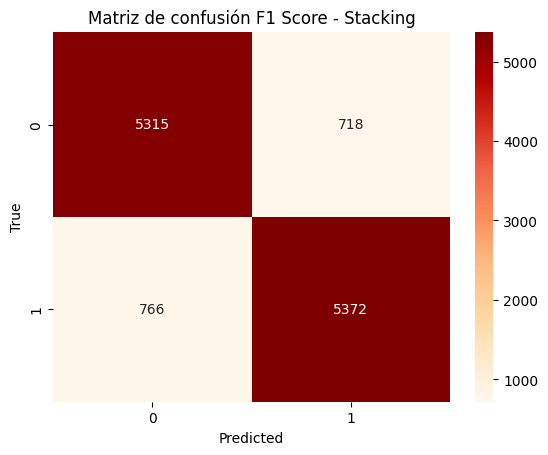

In [ ]:
# Hacemos predicción sobre el set de evaluacion
y_pred = stacking_model.predict(x_test_norm)

# Reporte y Matriz de Confusion
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='OrRd',annot=True,fmt='g')
plt.title("Matriz de confusión F1 Score - Stacking")
plt.xlabel('Predicted')
plt.ylabel('True')

#### Reporte de clasificación y matriz de confusión para Voting:

381/381 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      6033
           1       0.89      0.85      0.87      6138

    accuracy                           0.87     12171
   macro avg       0.88      0.87      0.87     12171
weighted avg       0.88      0.87      0.87     12171



Text(50.722222222222214, 0.5, 'True')

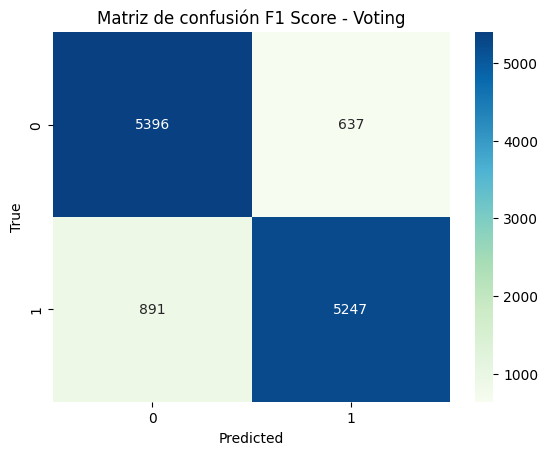

In [ ]:
# Hacemos predicción sobre el set de evaluacion
y_pred = vot_clf.predict(x_test_norm)

# Reporte y Matriz de Confusion
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='GnBu',annot=True,fmt='g')
plt.title("Matriz de confusión F1 Score - Voting")
plt.xlabel('Predicted')
plt.ylabel('True')

#### Comparamos todos los modelos

In [ ]:
# Evaluamos los scores de stacking
stacking_scores = evaluate_model(stacking_model, x_train_norm, y_train)
model_scores['stacking'] = stacking_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 77.5min finished


In [ ]:
print(stacking_scores)

[0.89257472 0.88815857 0.89615859 0.88547658 0.89739113 0.89195851
 0.8906234  0.8891742  0.89502876 0.89430978]


In [ ]:
# Evaluamos los scores de voting
voting_scores = evaluate_model(vot_clf, x_train_norm, y_train)
model_scores['voting'] = voting_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 17.4min finished


In [ ]:
print(voting_scores)

[0.87768306 0.87624525 0.88167625 0.87284306 0.88660641 0.87737496
 0.87983979 0.87777321 0.87890304 0.88095727]


In [ ]:
model_scores

defaultdict(None,
            {'RN': array([0.87429393, 0.88322892, 0.88249795, 0.88362777, 0.88249795,
                    0.8812776 , 0.88651535, 0.88218981, 0.88506574, 0.87880033]),
             'SVM': array([0.84091609, 0.84225121, 0.84593262, 0.83709942, 0.85065735,
                    0.84009448, 0.8419431 , 0.84233772, 0.84315941, 0.84377568]),
             'RF': array([0.86967238, 0.86618055, 0.86822104, 0.864318  , 0.87078882,
                    0.86833727, 0.8708021 , 0.86493426, 0.86647494, 0.86822104]),
             'KNN': array([0.84286741, 0.83578104, 0.84028348, 0.83011504, 0.84428924,
                    0.83649995, 0.8420458 , 0.83966721, 0.84161873, 0.8386401 ]),
             'XGB': array([0.88261271, 0.87963438, 0.88578472, 0.87859491, 0.88424404,
                    0.88066139, 0.88261271, 0.88311422, 0.88198439, 0.88670912]),
             'DT': array([0.85293211, 0.85375372, 0.85959326, 0.85322514, 0.85527938,
                    0.85765636, 0.85426723, 0.8523007

In [ ]:
# Graficamos los resultados
bar_plot_results(model_scores, name='stacking_model_cv')

---

## Aplicación de modelos al dataset de test

##### Lectura del dataset de test preprocesado:

In [ ]:
hotel_test = pd.read_csv('./dataset/hotels_test_preprocesado.csv')

##### Lectura del dataset de test original para mantener id:

In [ ]:
hotel_test_df = pd.read_csv('./dataset/hotels_test.csv')

##### Predicción y exportación:

In [ ]:
x_test_final = hotel_test[features]
x_test_final_cat = x_test_final[cols_categorical].copy()
x_test_final_cat.columns = cols_categorical

x_test_final_norm = pd.DataFrame(data=stand_scaler.transform(x_test_final[cols_to_normalize].copy()))
x_test_final_norm.columns = cols_to_normalize

x_test_final = pd.concat([x_test_final_norm, x_test_final_cat], axis=1)

In [ ]:
y_pred_final_stacking = stacking_model.predict(x_test_final)

y_pred_final_voting = vot_clf.predict(x_test_final)

830/830 [==============================] - 1s 2ms/step


In [ ]:
# TODO: asegurarse que y_pred_final tenga la forma correcta
y_pred_final_stacking

array([1, 1, 0, ..., 1, 1, 0])

In [ ]:
y_pred_final_voting

array([1, 1, 0, ..., 1, 1, 0])

Una prediccion correcta deberia ser alrededor del 50% para cada clase, ya que el dataset de test esta balanceado.

In [ ]:
counts = np.bincount(y_pred_final_stacking)
count_0 = counts[0]  # Cantidad de elementos 0
count_1 = counts[1]  # Cantidad de elementos 1

print("Resultado de la predicción STACKING: ")
print("No cancela:", count_0)
print("Cancela:", count_1)
print("Porceentaje de cancelaciones: {:.2f}%".format(count_1/(count_0+count_1)*100))

Resultado de la predicción STACKING: 
No cancela: 13213
Cancela: 13322
Porceentaje de cancelaciones: 50.21%


In [ ]:
counts = np.bincount(y_pred_final_voting)
count_0 = counts[0]  # Cantidad de elementos 0
count_1 = counts[1]  # Cantidad de elementos 1

print("Resultado de la predicción VOTING: ")
print("No cancela:", count_0)
print("Cancela:", count_1)
print("Porceentaje de cancelaciones: {:.2f}%".format(count_1/(count_0+count_1)*100))

Resultado de la predicción VOTING: 
No cancela: 13690
Cancela: 12845
Porceentaje de cancelaciones: 48.41%


In [ ]:
pd.concat([hotel_test_df['id'],pd.DataFrame(data=y_pred_final_stacking, columns=['is_canceled'])], axis=1).to_csv('./predicciones/pred_stacking_recargado.csv', index=False)

pd.concat([hotel_test_df['id'],pd.DataFrame(data=y_pred_final_voting, columns=['is_canceled'])], axis=1).to_csv('./predicciones/pred_voting_recargado.csv', index=False)

---

## Exportación de modelos

In [ ]:
dump(stacking_model, open('./modelos/model_stacking_recargado.pkl', 'wb'))

dump(vot_clf, open('./modelos/model_voting_recargado.pkl', 'wb'))

---